# Распознавание цифр, написанных от руки

**Распознайте рукописную цифру, написанную на листе от руки.**

Последовательность шагов:

1. На бумаге рисуем произвольную цифру (желательно нарисовать цифру размером не более 5 * 5 мм и без наклона. В занятии нейронка обучалась на цифрах американских студентов. Эти цифры были написаны на тетрадных листах в клетку и имели схожий размер)

2. Фотографируем

3. Загружаем фото в Colaboratory.

4. С помощью функции image.load_img(path, target_size=(28, 28), color_mode = ‘grayscale’) загружаем картинку в переменную.

5. С помощью функции image.img_to_array(img) преобразуем изображение в numpy-массив.

6. Выполняем инверсию цветов, нормирование и решейп массива.

7. Выполняем распознавание собственной рукописной цифры.

In [1]:
from pathlib import Path
import re
import tempfile
from typing import List

import gdown
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing import image

from matplotlib import pyplot as plt
%matplotlib inline

Определить каталог для загрузки изображений.

In [2]:
IMG_PATH = Path.cwd().parent.parent / 'data' / 'images' / '01-mnist'

Определить URL для загрузки весов предобученной нейронной сети.

In [3]:
WEIGHTS_URL = "https://drive.google.com/uc?export=download&id=1UMH1zOqscXugDnoW-gs3tcDQY9nPZwV4"

## Создание нейронной сети

In [4]:
model = Sequential()
model.add(
    Dense(
        800,
        input_dim=28*28,
        activation='relu'
    )
)
model.add(
    Dense(
        400,
        activation='relu'
    )
)
model.add(
    Dense(
        10,
        activation='softmax'
    )
)

Скачать веса нейронной сети с Google Диск.

In [5]:
weights_path = Path(tempfile.gettempdir()) / 'aiu-01-mnist-ultra-light-model.h5'
gdown.cached_download(WEIGHTS_URL, path=weights_path, quiet=False);

File exists: C:\Users\divos\AppData\Local\Temp\aiu-01-mnist-ultra-light-model.h5


Загрузить веса нейронной сети.

In [6]:
model.load_weights(weights_path)

## Распознавание цифр на изображениях

### Распознавание цифр, написанных карандашом на бумаге

Загрузить набор цифр, написанных карандашом. Изображения были предварительно обесцвечены в графическом редакторе.

In [7]:
images_org = []
for path in IMG_PATH.iterdir():
    match = re.match(r'^.*(\d)l.png$', str(path))
    if match:
        images_org.append(
            (
                int(match[1]),
                image.load_img(path, target_size=(28, 28), color_mode='grayscale'),
            )
        )

images_org.sort(key=lambda item: item[0])

Отобразить загруженные изображения.

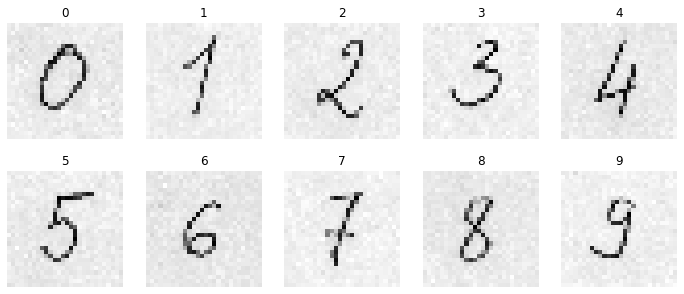

In [8]:
_, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for idx, (image_org, ax) in enumerate(zip(images_org, axes)):
    ax.imshow(image_org[1], cmap='gray')

    ax.set_title(str(idx))
    ax.set_axis_off()

plt.show();

Выполнить инверсию цветов и нормирование. Индекс элемента в списке `digits` соответствует распознаваемой цифре.

In [9]:
digits = []
for _, img in images_org:
    digit = image.img_to_array(img)
    digits.append(np.clip(1. - digit / digit.max(), 0., 1.))

Отобразить результаты инверсии цветов и нормирования.

In [10]:
def plot_digits(digits: List[np.ndarray]):
    _, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.flatten()

    for idx, (digit, ax) in enumerate(zip(digits, axes)):
        ax.imshow(digit, cmap='gray')

        ax.set_title(str(idx))
        ax.set_axis_off()

    plt.show()

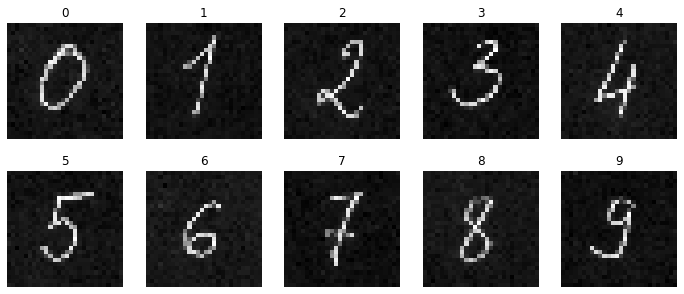

In [11]:
plot_digits(digits);

Удалить шум на фоне цифр.

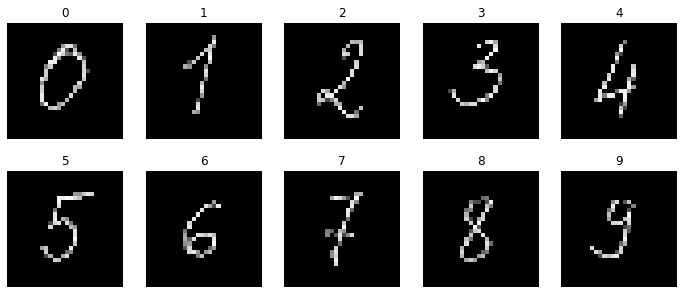

In [12]:
digits = [np.where(digit < 0.15, 0., digit) for digit in digits]

plot_digits(digits);

Выполнить линейное контрастирование.

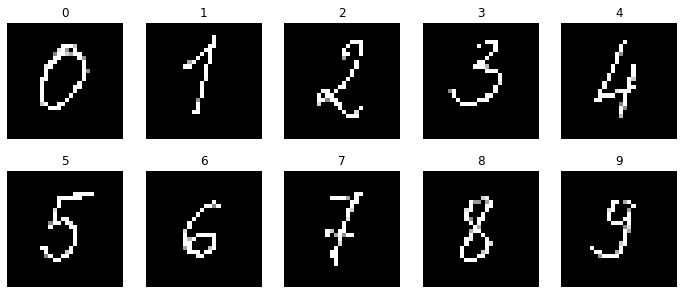

In [13]:
digits = [np.clip(0.5 * digit / 0.15, 0., 1.) for digit in digits]

plot_digits(digits);

Изменить размер массивов и подготовить данные для распознавания.

In [14]:
data = np.array([digit.flatten() for digit in digits])

print(data.shape)

(10, 784)


Выполнить распознавание данных нейронной сетью.

In [15]:
predicted = np.argmax(model.predict(data, verbose=True), axis=0)

1/1 [==============================] - 0s 2ms/step


Отобразить результаты распознавания. Так как индекс в списке соответствует распознаваемой цифре, то будем сравнивать индексы элементов с их значениями.

In [16]:
count = 0

for idx, value in enumerate(predicted):
    if idx == value:
        fmt = "Требуется: {}, предсказано: {}"
        count += 1
    else:
        fmt = "Требуется: {}, предсказано: {}, несовпадение!"

    print(fmt.format(idx, value))

print(f"\nAccuracy: {count / len(predicted)}")

Требуется: 0, предсказано: 0
Требуется: 1, предсказано: 1
Требуется: 2, предсказано: 2
Требуется: 3, предсказано: 3
Требуется: 4, предсказано: 4
Требуется: 5, предсказано: 5
Требуется: 6, предсказано: 6
Требуется: 7, предсказано: 7
Требуется: 8, предсказано: 8
Требуется: 9, предсказано: 9

Accuracy: 1.0


### Распознавание цифр, написанных маркером на бумаге

Загрузить набор цифр, написанных маркером. Изображения были предварительно обесцвечены в графическом редакторе.

In [17]:
images_org.clear()
for path in IMG_PATH.iterdir():
    match = re.match(r'^.*(\d)b.png$', str(path))
    if match:
        images_org.append(
            (
                int(match[1]),
                image.load_img(path, target_size=(28, 28), color_mode='grayscale'),
            )
        )

images_org.sort(key=lambda item: item[0])

Отобразить загруженные изображения.

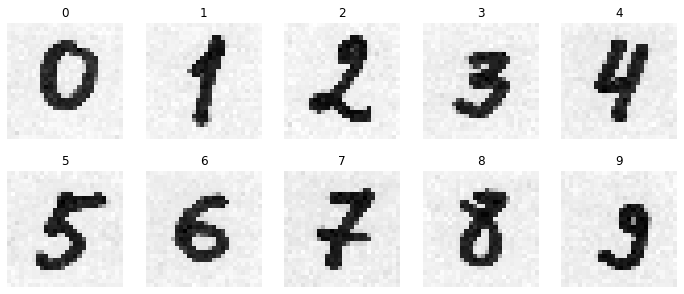

In [18]:
_, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for idx, (image_org, ax) in enumerate(zip(images_org, axes)):
    ax.imshow(image_org[1], cmap='gray')

    ax.set_title(str(idx))
    ax.set_axis_off()

plt.show();

Выполнить инверсию цветов и нормирование. Индекс элемента в списке `digits` соответствует распознаваемой цифре.

In [19]:
digits.clear()
for _, img in images_org:
    digit = image.img_to_array(img)
    digits.append(np.clip(1. - digit / digit.max(), 0., 1.))

Отобразить результаты инверсии цветов и нормирования.

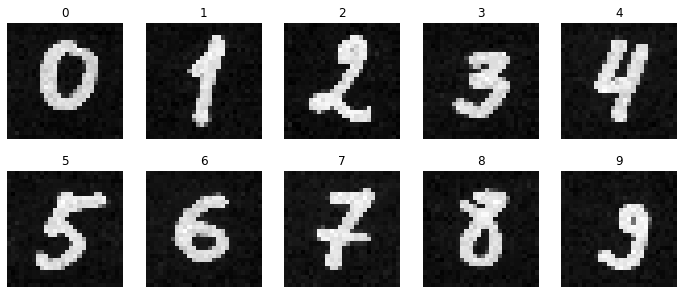

In [20]:
plot_digits(digits);

Удалить шум на фоне цифр.

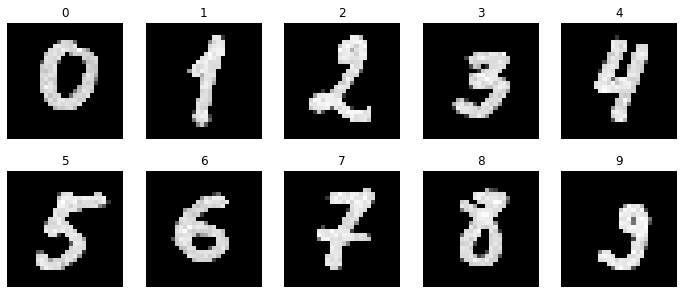

In [21]:
digits = [np.where(digit < 0.15, 0., digit) for digit in digits]

plot_digits(digits);

Изменить размер массивов и подготовить данные для распознавания.

In [22]:
data = np.array([digit.flatten() for digit in digits])

print(data.shape)

(10, 784)


Выполнить распознавание данных нейронной сетью.

In [23]:
predicted = np.argmax(model.predict(data, verbose=True), axis=0)

1/1 [==============================] - 0s 2ms/step


Отобразить результаты распознавания. Так как индекс в списке соответствует распознаваемой цифре, то будем сравнивать индексы элементов с их значениями.

In [24]:
count = 0

for idx, value in enumerate(predicted):
    if idx == value:
        fmt = "Требуется: {}, предсказано: {}"
        count += 1
    else:
        fmt = "Требуется: {}, предсказано: {}, несовпадение!"

    print(fmt.format(idx, value))

print(f"\nAccuracy: {count / len(predicted)}")

Требуется: 0, предсказано: 0
Требуется: 1, предсказано: 1
Требуется: 2, предсказано: 2
Требуется: 3, предсказано: 3
Требуется: 4, предсказано: 4
Требуется: 5, предсказано: 5
Требуется: 6, предсказано: 6
Требуется: 7, предсказано: 7
Требуется: 8, предсказано: 8
Требуется: 9, предсказано: 0, несовпадение!

Accuracy: 0.9
